In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_parquet("data/creditcard.parquet")
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
dataset_arr = df.to_numpy()
X, y = dataset_arr[:, :-1].astype(np.float64), dataset_arr[:, -1].astype(np.uint8)

In [7]:
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate((intercept, X), axis=1)

In [8]:
n_classes = np.unique(y, axis=0).shape[0]
n_samples = y.shape[0]
y_encoded = np.array([np.zeros(n_classes) for _ in range(n_samples)])
y_encoded[np.arange(n_samples), y] = 1

In [9]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_b, y_encoded, test_size=val_size, random_state=random_state, shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle
)

In [10]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

In [13]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / exp_z.sum(axis=1)[:, None]


def predict(X, theta):
    z = np.dot(X, theta)
    y_hat = softmax(z)
    return y_hat


def compute_loss(y_hat, y):
    n = y.shape[0]
    return (-1 / n) * np.sum(y * np.log(y_hat))


def compute_gradient(X, y, y_hat):
    n = y.shape[0]
    return np.dot(X.T, (y_hat - y)) / n


def update_theta(theta, gradient, lr):
    return theta - lr * gradient


def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    acc = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean()
    return acc

In [14]:
lr = 0.01
epochs = 30
batch_size = 1024
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(size=(n_features, n_classes))

In [15]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i : i + batch_size]
        y_i = y_train[i : i + batch_size]

        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_hat, y_i)
        gradient = compute_gradient(X_i, y_i, y_hat)
        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)
        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_batch_losses = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_losses = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_losses)
    val_losses.append(val_batch_losses)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(
        f"EPOCH {epoch + 1}:\tTraining loss: {train_batch_losses:.3f}\tValidation loss: {val_batch_losses:.3f}"
    )

EPOCH 1:	Training loss: 0.477	Validation loss: 0.470
EPOCH 2:	Training loss: 0.196	Validation loss: 0.193
EPOCH 3:	Training loss: 0.111	Validation loss: 0.110
EPOCH 4:	Training loss: 0.076	Validation loss: 0.075
EPOCH 5:	Training loss: 0.059	Validation loss: 0.058
EPOCH 6:	Training loss: 0.048	Validation loss: 0.047
EPOCH 7:	Training loss: 0.041	Validation loss: 0.041
EPOCH 8:	Training loss: 0.036	Validation loss: 0.035
EPOCH 9:	Training loss: 0.032	Validation loss: 0.032
EPOCH 10:	Training loss: 0.029	Validation loss: 0.029
EPOCH 11:	Training loss: 0.027	Validation loss: 0.026
EPOCH 12:	Training loss: 0.025	Validation loss: 0.024
EPOCH 13:	Training loss: 0.023	Validation loss: 0.022
EPOCH 14:	Training loss: 0.022	Validation loss: 0.021
EPOCH 15:	Training loss: 0.020	Validation loss: 0.020
EPOCH 16:	Training loss: 0.019	Validation loss: 0.019
EPOCH 17:	Training loss: 0.018	Validation loss: 0.018
EPOCH 18:	Training loss: 0.018	Validation loss: 0.017
EPOCH 19:	Training loss: 0.017	Valida

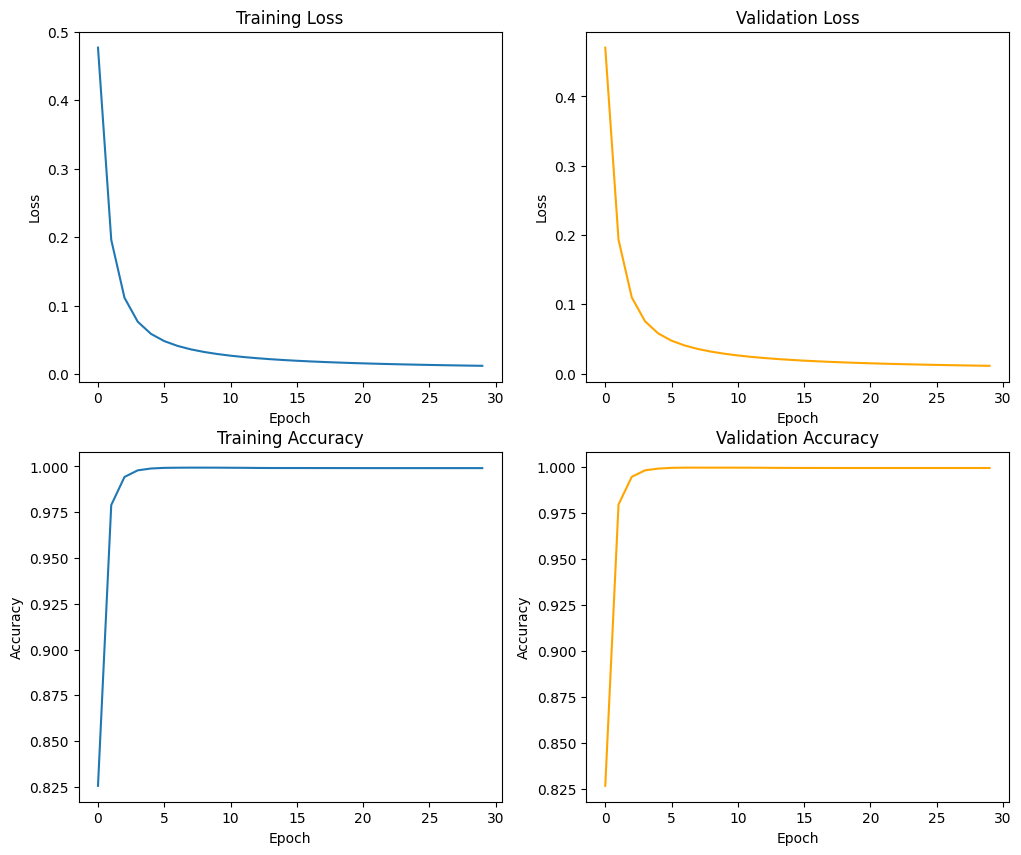

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(val_losses, "orange")
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Validation Loss")

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(val_accs, "orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Validation Accuracy")

plt.show()

In [17]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print("Evaluation on validation and test set:")
print(f"Accuracy: {val_set_acc}")
print(f"Accuracy: {test_set_acc}")

Evaluation on validation and test set:
Accuracy: 0.9992802219023208
Accuracy: 0.9992626663389628
